In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from astropy    import units
from matplotlib import pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

from common import hallmark as hm
from common import mockservation as mk
from common import dalt
from common import viz

## Load simulation data from cache

In [2]:
pf = hm.ParaFrame('cache/Illinois_thermal_w{win:d}/{mag}a{aspin:g}_i{inc:d}/gt_Rh{Rhigh:d}_{freq}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

inc [ 10  30  50  70  90 110 130 150 170]
freq ['230GHz' '2um' '86GHz']
aspin [-0.94 -0.5   0.    0.5   0.94]
win [1 2 3 4 5]
Rhigh [  1  10  40 160]
mag ['M' 'S']


<AxesSubplot:xlabel='$x$ [$\\mathrm{\\mu as}$]', ylabel='$y$ [$\\mathrm{\\mu as}$]'>

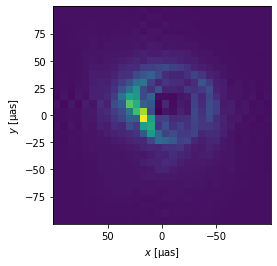

In [3]:
def load(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
    return dalt.Image(data, meta=meta)
        
mov = load(pf(freq='230GHz').path.iloc[64])
viz.show(mov, s=0)

<AxesSubplot:xlabel='u [G$\\lambda$]', ylabel='v [G$\\lambda$]'>

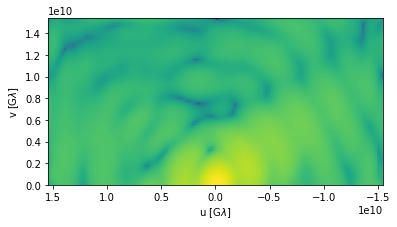

In [4]:
vis = mk.mockserve(mov, N=128)
viz.show(vis, s=0, f=lambda v: np.log(abs(v).value))

In [5]:
U, V = vis.uvd

u = np.linspace( 0,   U/2, num=vis.shape[-1])
v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
t = vis.meta.time.value

amp = RegularGridInterpolator((t, v, u[::-1]), abs     (vis[...,::-1]))
phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))

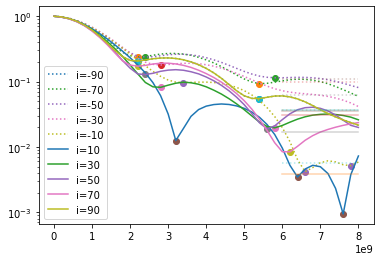

In [6]:
bmin = 6e9
bmax = 8e9

uvd = np.linspace(0, bmax, round(bmax/2e8)+1)

for i in range(-90,90+1,20):
    phi = np.pi * i / 180

    u = uvd * np.cos(phi)
    v = uvd * np.sin(phi)

    mask = u <= 0
    
    p = np.array([np.repeat(t[0], np.sum( mask)),  v[ mask],  u[ mask]]).T
    m = np.array([np.repeat(t[0], np.sum(~mask)), -v[~mask], -u[~mask]]).T
    
    s = np.zeros(len(uvd))
    s[ mask] = amp(p)
    s[~mask] = amp(m)
        
    plt.semilogy(uvd, s/s[0], ':' if i < 0 else '-', label=f'i={i}')

    lm = argrelextrema(s, np.less)[0]
    plt.scatter(uvd[lm], s[lm]/s[0])
    
    ms = np.median(s[(bmin < uvd) & (uvd < bmax)]) / s[0]
    plt.plot([bmin, bmax], [ms, ms], ':' if i < 0 else '-', alpha=1/3)

plt.legend()